# Question 1

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import scipy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM

In [4]:
#This function finds the best single split on one of the two variables, while incorporating weights.
# Inputs:
## X: a numpy array with 2 columns
## y: a numpy array with n elements
## wgts: a numpy array of n observation weights.
# Returns two things:
## fit: The object returned by DecisionTreeClassifier
## tree_info: A dictionary with the following additional info. You don't need this, but it might help debug.
##   variable_idx: Number of selected variable column
##   threshold: Where that variable was split
##   guess_less: which category is guessed if less than threshold
##   guess_greater: which category is guessed if greater than threshold
def find_split(X, y, wgts=None):
    n = X.shape[0]
    dtc = DecisionTreeClassifier(max_depth=1)
    fit = dtc.fit(X,y, sample_weight=wgts)
    tree_info = {
        'variable_idx' : fit.tree_.feature[0],
        'threshold' : fit.tree_.threshold[0],
        'guess_less' : np.argmax(fit.tree_.value[1])*2-1,
        'guess_greater' : np.argmax(fit.tree_.value[2])*2-1
    }
    return(fit, tree_info)

In [5]:
#Draws the data points and the decision boundaries used by the boosted trees.  
#If score is supplied, the points are also shaded by the score.
# Inputs:
## trees: the list of tree objects output by my_adaboost
## X: a set of points output by get_circle_data (no y is needed)
## score: n-vector of scores to color each point (optional)
# Outputs: makes a plot.  You still need to call plt.show()
def draw_boosted_trees(trees, X, score=None):
    if score is not None:
        plt.scatter(X[:,0], X[:,1], c=score, cmap=plt.get_cmap('plasma'))
    else:
        plt.scatter(X[:,0], X[:,1])
    line_col='grey'
    for fit in trees:
        variable_idx = fit.tree_.feature[0]
        threshold = fit.tree_.threshold[0]
        if variable_idx==0:
            plt.axvline(x = threshold, color=line_col)
        else:
            plt.axhline(y = threshold, color=line_col)

In [6]:
# Generates data for our example
# Inputs:
## n: number of samples
# Output: list with entries:
## X: an nx2 matrix of data points.
## y: class for the point (-1,1)
def get_circle_data(n):
    gaussian_2d = scipy.stats.multivariate_normal(mean = np.zeros(2), cov = np.eye(2))
    X = gaussian_2d.rvs(n)
    Y = np.where(X[:,0]**2+X[:,1]**2<1, 1, -1)
    return(X,Y)

### Part (a)

In [53]:
# Implement the adaboost function in my_adaboost
# Inputs:
## X, y: Data produced by get_circle_data()
## B: The number of trees to produce during boosting
# Returns:
## trees: a list of fitted tree objects
## alphas: a numpy array of B alpha values for the trees
def my_adaboost(X, y, B=10):
    n = X.shape[0]
    #Observation weights
    wgts = np.repeat(1/n, n)
    trees = []#To store your trees.  Use append()
    alphas = np.zeros(B)#To store your alphas
    for b in range(B):
        #Find the next split, according to your current weights.
        #Hint: the returned tree supports predict()
        tree, info = find_split(X, y, wgts)
        y_hat = tree.predict(X)
        e_b = np.sum(wgts*(y_hat!=y))/np.sum(wgts)
        alphas[b] = np.log((1-e_b)/e_b)
        trees.append(tree)
        wgts = wgts*np.exp(alphas[b]*(y_hat!=y))
    return(trees, alphas)

In [17]:
#Calculate predictions for boosted trees from my_adaboost.  
#If passed true y values, also computes *running* misclassification error across all B.
# Inputs:
## trees: list of trees returned by my_adaboost
## alphas: alpha vector returned by my_adaboost
## X: a data set to make predictions on
## y: the true labels for that data set, in {-1,1}.  If given, running prediction error is computed.
# Outputs: a list containing:
## score: the score for each point (before thresholding)
## preds: the thresholded scores: our guesses at class.
## test_err: a length B vector of misclassification error at each step (1 tree to B trees)
def predict_ada(trees, alphas, X, y=None):
    n = X.shape[0]
    #Initialize a score vector to zero.  
    #This will store the ongoing sum alpha_b fhat_b(x) for each point.
    score = np.zeros(n)
    B = len(trees)
    #This will store the misclassification error at each step,
    # so we can see how it changes with the number of trees
    test_err = np.zeros(B)
    for b in range(B):
        #Update your score to include the contribution from tree b
        score = score + alphas[b]*trees[b].predict(X)
        preds = np.sign(score)#TODO: Make predictions in {-1,1}#
        if y is not None:
            #Record the misclassification error for the predictions 
            #based on thresholding the current score
            test_err[b] = np.mean(preds!=y)
    if y is None:
        return(score, preds)    
    return(score, preds, test_err)


In [107]:
#Calculates the partial dependence plot over the first column of X
#Fixes the first column at each point in the grid and evaluates the 
#predictions at all of these fake points.  These predictions are used
# to obtain the partial dependence over x1.
# Inputs:
## trees: list of trees returned by my_adaboost
## alphas: list of alphas returned by my_adaboost
## X: data set to use for computing partial dependence.
def calculate_partial_dependence_x1(trees, alphas, X):
    m = 50#Number of grid points to evaluate partial dependence
    x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), m)
    
    #Somewhere to store the partial dependence values
    pdep = np.zeros(m)

    #We will fake a dataset and change its x1 values to match each evaluation points
    fake = X.copy()
    for i in range(m):
        fake[:,0] = x[i]
        #TODO: Fill in the actual calculation of the partial 
        # dependence at x[i] below#
        #HINT: Evaluate predict_ada on the fake data set and use 
        # resulting predictions
        _,preds =  predict_ada(trees,alphas,fake)
        pdep[i] = np.mean(preds)
    return(x, pdep)

### part (b)

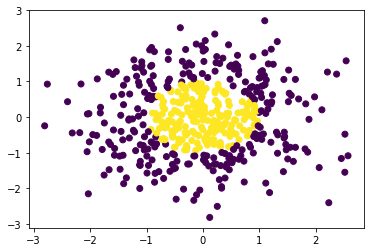

In [50]:
train = get_circle_data(n=500)
test = get_circle_data(n=500)
train_data_plot = plt.scatter(train[0][:,0],train[0][:,1],c=train[1])

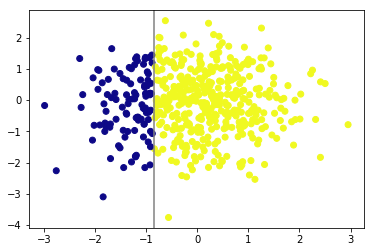

In [79]:
# Draws the boundary, scores for B = 1
boosted_tress,alphas = my_adaboost(train[0],train[1],B=1)
scores,preds = predict_ada(boosted_tress,alphas,test[0])
draw_boosted_trees(boosted_tress, test[0],score=scores)

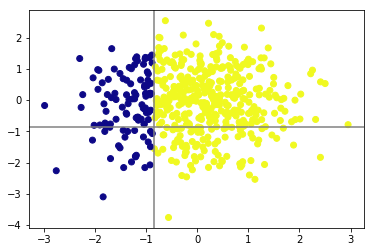

In [80]:
# Draws the boundary, scores for B = 2
boosted_tress,alphas = my_adaboost(train[0],train[1],B=2)
scores,preds = predict_ada(boosted_tress,alphas,test[0])
draw_boosted_trees(boosted_tress, test[0],score=scores)

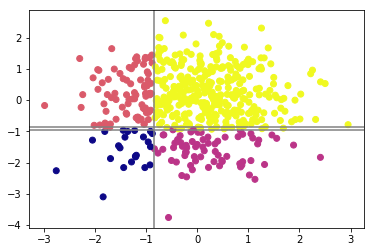

In [81]:
# Draws the boundary, scores for B = 3
boosted_tress,alphas = my_adaboost(train[0],train[1],B=3)
scores,preds = predict_ada(boosted_tress,alphas,test[0])
draw_boosted_trees(boosted_tress, test[0],score=scores)

### part (c)

In [89]:
boosted_tress,alphas = my_adaboost(train[0],train[1],B=250)
train_scores,train_preds,train_errors = predict_ada(boosted_tress,alphas,train[0],y=train[1])
test_scores,test_preds,test_errors = predict_ada(boosted_tress,alphas,test[0],y=test[1])

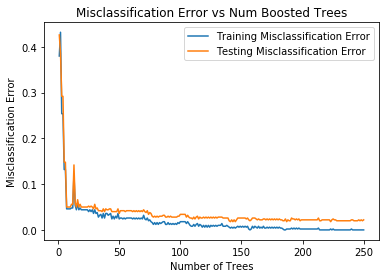

In [114]:
plt.plot(range(1,251),train_errors,label="Training Misclassification Error")
plt.plot(range(1,251),test_errors,label="Testing Misclassification Error")
plt.gca().legend()
plt.xlabel("Number of Trees")
plt.ylabel("Misclassification Error")
plt.title("Misclassification Error vs Num Boosted Trees")
plt.show()

Decision Boundary by boosted trees - Train Set


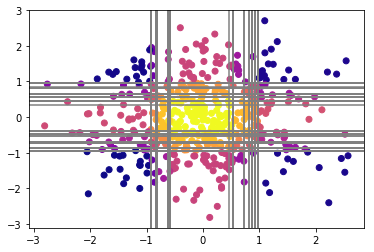

In [113]:
draw_boosted_trees(boosted_tress,train[0],train_scores)
print("Decision Boundary by boosted trees - Train Set")

Decision Boundary by boosted trees - Test Set


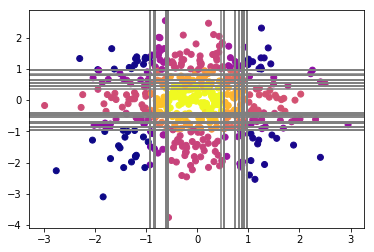

In [112]:
draw_boosted_trees(boosted_tress,test[0],test_scores)
print("Decision Boundary by boosted trees - Test Set")

In [99]:
print("Test Misclassification error :",test_errors[249])

Test Misclassification error : 0.022


As shown in above calculations, many boosted tress are able to build decision boundary which can classify label separated by circle. The misclassification error is very small as can be seen from the plots. The test misclassification error is only 0.022.

### Part (d)

I plot the partial dependence plot below which plots the average prediction made by the adaboost classifier. The shown outcome is expected as pointrs in the range of $x_1<-1$ and $x_1>1$ are definitely outside the unit circle and this label is -1. 

For $-1 \leq x_1\leq 1$, approximately 70% of the datapoints will have $-1 \leq x_2 \leq 1$ and 30.% outside this range. These are estimates of the volume of a 2-D gaussian bell shaped surface around 1 standard deviation from the mean. In 1-D the probability of falling within 1 standard deviation from the mean is approximately 70%. For points falling inside the circle, label is 1.0 and for points outside, it's -1.0, so the expected average prediction value is $0.7\times 1.0 + 0.3\times (-1.0) = 0.4$ which is observed in the partial dependence plot.

Text(0.5,1,'Partial Dependence Plot')

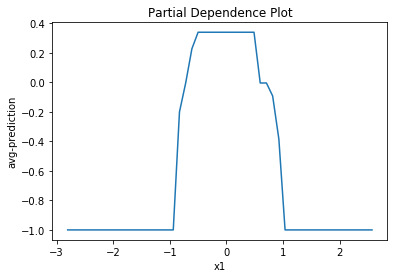

In [111]:
x,y = calculate_partial_dependence_x1(boosted_tress, alphas, train[0])
plt.plot(x,y)
plt.xlabel("x1")
plt.ylabel("avg-prediction")
plt.title("Partial Dependence Plot Average Prediction - ")

# Question 2

In [3]:
X = pd.read_csv("housing_X.csv")
y = pd.read_csv("housing_y.csv",header=None)

In [4]:
y.rename(columns={0:'Value'},inplace=True)

In [91]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
X, y, test_size=0.4, random_state=1)
X_test, X_final, y_test, y_final = train_test_split(
X_tmp, y_tmp, test_size=0.5, random_state=10)

### Part (a)

In [92]:
xgbfit = xgb.XGBRegressor()
xgbfit.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [93]:
y_test_hat = xgbfit.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  37583.454


### Part (b)

In [94]:
rf_fit = RandomForestRegressor(n_estimators=500)
rf_fit.fit(X_train,y_train)


C:\Users\shuva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
y_test_hat = rf_fit.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  32255.162


MAE of the Random Forest regression is less than the default XGBoost regression, which means the Random Forest based regression model performs better than the default XGBoost regression in test data.

### Part (c)

In [11]:
train_dm = xgb.DMatrix(X_train, y_train)
test_dm = xgb.DMatrix(X_test, y_test)

In [12]:
cv_result = xgb.cv(params={'silent':1,'n_estimators':1000,'eval_metric':'mae'},dtrain=train_dm,metrics='mae',
                   nfold=5,num_boost_round=1000)

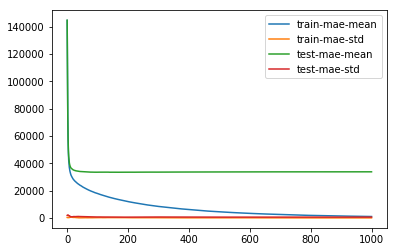

In [13]:
cv_result.plot()

From above plot, I can observe that the training error keeps reducing with increasing number of boosted trees but the test error remains flat after a certain number of trees. This shows that beyond that number of trees, the model will start overfitting to the data resulting into lowered training error but with no improvement in test error.

In [14]:
n_tree = np.argmin(cv_result['test-mae-mean'])

C:\Users\shuva\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [16]:
cv_xgbfit = xgb.XGBRegressor(n_estimators=n_tree)
cv_xgbfit.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
y_test_hat = cv_xgbfit.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  34981.084


The test MAE using the XGboost fit using cross validated number of trees has definitely improved. The MAE is still not less than the MAE by the Random Forest regressor.

### part (d)

In [56]:
param = {'max_depth':[3,6,9,12],'min_child_weight':[1,4,8,16]}
estimator = xgb.XGBRegressor(n_estimators=n_tree)
grid_search = GridSearchCV(estimator, param_grid=param, scoring='neg_mean_absolute_error')

In [31]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 6, 9, 12], 'min_child_weight': [1, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [36]:
cv_selected_params = grid_search.best_params_
print(cv_selected_params)

{'max_depth': 9, 'min_child_weight': 8}


In [34]:
cv_xgbfit2 = xgb.XGBRegressor(n_estimators=n_tree,max_depth=cv_selected_params['max_depth'],
                              min_child_weight=cv_selected_params['min_child_weight'])
cv_xgbfit2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=8, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
y_test_hat = cv_xgbfit2.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  30900.365


Using the grid search cross validation, max_depth of 9 and min_child_weight of 8 are the parameter values with best performance in cross validation. I refit the XGBoost regression model using the chosen parameter values and the MAE has significantly improved beating the Random Forest based regression model.

### Part (e)

In [109]:
param = {
'max_depth': [3,6,9,12],
'min_child_weight': [1,4,8,16],
'learning_rate': [0.05, 0.1, 0,3, 0.5, 0.7],
'gamma': [0, 10, 100, 1000],
'subsample': [0.1, 0.3, 0.5, 1],
'colsample_bylevel': [0.5, 0.7, 1]
}
estimator = xgb.XGBRegressor(n_estimators=n_tree)
randomized_search = RandomizedSearchCV(estimator,n_iter=16, param_distributions=param, scoring='neg_mean_absolute_error')

In [116]:
randomized_search.fit(X_train,y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=16, n_jobs=1,
          param_distributions={'max_depth': [3, 6, 9, 12], 'min_child_weight': [1, 4, 8, 16], 'learning_rate': [0.05, 0.1, 0, 3, 0.5, 0.7], 'gamma': [0, 10, 100, 1000], 'subsample': [0.1, 0.3, 0.5, 1], 'colsample_bylevel': [0.5, 0.7, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [117]:
randomized_cv_selected_param = randomized_search.best_params_
print(randomized_cv_selected_param)

{'subsample': 1, 'min_child_weight': 8, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 100, 'colsample_bylevel': 0.7}


In [118]:
cv_xgbfit3 = xgb.XGBRegressor(n_estimators = n_tree, max_depth = randomized_cv_selected_param['max_depth'],
                              colsample_bylevel=randomized_cv_selected_param['colsample_bylevel'],
                              gamma=randomized_cv_selected_param['gamma'],
                              subsample=randomized_cv_selected_param['subsample'],
                              learning_rate= randomized_cv_selected_param['learning_rate'],
                              min_child_weight = randomized_cv_selected_param['min_child_weight'])
cv_xgbfit3.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1, gamma=100, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=8, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [119]:
y_test_hat = cv_xgbfit3.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  30670.129


Above shows the parameters chosen by the randomized search. The test MAE with this set of parameters made further improvements and is better than model calibrated in part (d).

### Part (f)

Below are the parameters for the best XGboost regression fit I found based on cross validation of several combination at a time. Achieved Test MSE by this model is best among all the models so far.

In [88]:
best_num_tree = n_tree
best_max_depth = 9
best_subsample = 1
best_min_child_weight = 4
best_reg_lambda = 0.8
cv_xgbfit_best = xgb.XGBRegressor(n_estimators=best_num_tree,max_depth=best_max_depth,
                              min_child_weight= best_min_child_weight,
                              colsample_bylevel=0.7,
                              subsample = best_subsample,
                             reg_lambda = best_reg_lambda,)
cv_xgbfit_best.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=4, missing=None, n_estimators=191,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [90]:
y_test_hat = cv_xgbfit_best.predict(X_test)
MAE = mean_absolute_error(y_test['Value'],y_test_hat)
print("MAE on test set: ", round(MAE,3))

MAE on test set:  30360.127


### Part (g)

In [122]:
models = {'Default XGBoost': xgbfit,'Random Forest':rf_fit,'CV_c':cv_xgbfit,
          'CV_d':cv_xgbfit2, 'CV_e':cv_xgbfit3, 'CV_f':cv_xgbfit_best}

for k in models:
    print('Calculating Final test results on model:,',k)
    y_final_test_hat = models[k].predict(X_final)
    final_MAE = mean_absolute_error(y_final['Value'],y_final_test_hat)
    print('MAE on model :', k, 'is', round(final_MAE,3))
    print('\n')

Calculating Final test results on model:, Default XGBoost
MAE on model : Default XGBoost is 37771.373


Calculating Final test results on model:, Random Forest
MAE on model : Random Forest is 32271.177


Calculating Final test results on model:, CV_c
MAE on model : CV_c is 35118.536


Calculating Final test results on model:, CV_d
MAE on model : CV_d is 30612.159


Calculating Final test results on model:, CV_e
MAE on model : CV_e is 30753.703


Calculating Final test results on model:, CV_f
MAE on model : CV_f is 30568.413




The Final Test Set MAE is close to the previously calculated test set MAE. In some cases the final test MAE is less than previous MAE for example model calibrated in part (d), and in many cases the final test MAE is more than previous MAE for example model calibrated in part (f). Overall the ordering of the models based on test set MAE remains the same based on final test set MAE, whic shows that our models hasn't overfit to the train, test data.

The best calibrated based on validation test set MAE in part (f) remains the best based in final test MAE as well.

# Question 3

In [132]:
train_data = pd.read_csv('problem3_train.csv')
test_data = pd.read_csv('problem3_test.csv')
X_train = train_data.loc[:,'X1':'X50']
y_train = train_data.loc[:,'y']
X_test = test_data.loc[:,'X1':'X50']
y_test = test_data.loc[:,'y']

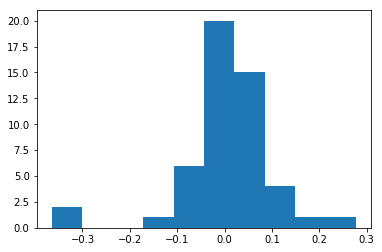

In [133]:
correlations = np.apply_along_axis(stats.pearsonr,0,X_train,y_train)
plot = plt.hist(correlations[0,:],bins=10)

Above plot shows the distribution of the pairwise linear correlation between each of the predictor variable and response variable which shows very small amount of relation present between the variables. 

### Part (a)


In [134]:
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)
yhat_lm = lmfit.predict(X_test)
print('Test Set Error with Logistic Regression :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = lmfit.predict(X_train)
print('Train Set Error with Logistic Regression :',round(np.mean(y_train!=yhat_lm),4))

Test Set Error with Logistic Regression : 0.2383
Train Set Error with Logistic Regression : 0.1433


I believe applying Logistic regression with no regularization is already an approach which has a lot of bias and assumption around the data. Reducing some of the bias to improve the generalization would help brining down the test error, thus I believe we need to filter noisy variables by Lasso regression and then reduce some of the bias by trying a more flexible GAM model. Addition of further bias will not help improving the test error.

### Part (b)

In [135]:
lassofit = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=50).fit(X_train, y_train)

In [136]:
yhat_lm = lassofit.predict(X_test)
print('Test Set Error with Logistic Lasso CV Regression :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = lassofit.predict(X_train)
print('Train Set Error with Logistic Lasso CV Regression :',round(np.mean(y_train!=yhat_lm),4))

Test Set Error with Logistic Lasso CV Regression : 0.1871
Train Set Error with Logistic Lasso CV Regression : 0.1933


I definitely see improvement of the test error compared to previous logistic regression fit. Also below are the co-efficients fit by the lasso logistic regression. I can see only 5 variables among 50 have non-zero coefficient. Those variables are $X_9$, $X_{20}$,$X_{22}$,$X_{31}$,$X_{40}$.

In [137]:
lassofit.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.03150435,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.55975805,
         0.        ,  0.05076241,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.37921566,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.45358485,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

### Part (c)

In [138]:
rf_fit = RandomForestClassifier(n_estimators=500,oob_score=True)
treefit = rf_fit.fit(X_train,y_train)

In [139]:
yhat_lm = treefit.predict(X_test)
print('Test Set Error with Random Forest :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = treefit.predict(X_train)
print('Train Set Error with Random Forest :',round(np.mean(y_train!=yhat_lm),4))
print("OOB error for Random Forest fit is", 1-round(treefit.oob_score,4))

Test Set Error with Random Forest : 0.2337
Train Set Error with Random Forest : 0.0
OOB error for Random Forest fit is 0


Although the Random Forest perfectly fits the training data, it performs very poorly on the test data which is worse than the lasso fit. This is essentially overfitting to the data and we need to put some kind of regularization to prevent overfitting. I plot the feature importance to find more about the random forest decision process.

Looks like there 4 features which are particularly important but there are other features as well with moderate amount of importance. We should use cross validation to pick few of the hyperparameters to improve the random forest fit.

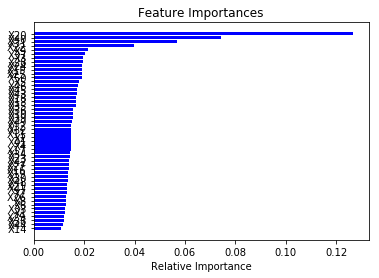

In [140]:
features = X_train.columns
importances = treefit.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

I perform cross validation to improve the accuracy and also find that the dataset is not balanced and there are approximately 67% data with label 1 and rest with label 0. We should use the balanced approach in building the random forest so that less frequent data sets gets more weight in the model. So I fit below random forest tree which performs at par with the lasso fit but not any better than that.

In [141]:
rf_fit2 = RandomForestClassifier(n_estimators=500,oob_score=True,class_weight='balanced',
                                 min_samples_leaf=10,min_samples_split=25)
treefit2 = rf_fit2.fit(X_train,y_train)
yhat_lm = treefit2.predict(X_test)
print('Test Set Error with Regularized Random Forest :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = treefit2.predict(X_train)
print('Train Set Error with Regularized Random Forest :',round(np.mean(y_train!=yhat_lm),4))
print("OOB error for Random Forest fit is", 1-round(treefit2.oob_score,4))

Test Set Error with Regularized Random Forest : 0.1884
Train Set Error with Regularized Random Forest : 0.0167
OOB error for Random Forest fit is 0


Below is the feature importance plot of the regularized tree which shows much better feature selection and many of the other features are now deemed unimportant. Similar to lasso, the random forest model only picks four features as important and classifies the rest as irrelevant.

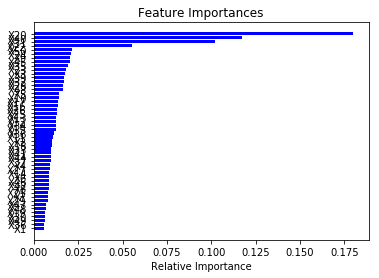

In [142]:
features = X_train.columns
importances = treefit2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

To reduce the noise further I look at the feature importances and select top four features with relative importance more than 0.05 and run the model only with those four variables. Given this selection of features is based on training data only, we are not making any validation mistake. I refit another random forest classifier using only four features namely $X_{20}$, $X_{40}$, $X_{31}$ and $X_{22}$ and the test error shows significant reduction and performs better than the lasso model fit.

In [143]:
rf_fit3 = RandomForestClassifier(n_estimators=500,oob_score=True,class_weight='balanced',
                                 min_samples_leaf=10,min_samples_split=25)
treefit3 = rf_fit3.fit(X_train[['X20','X40','X31','X22']],y_train)
yhat_lm = treefit3.predict(X_test[['X20','X40','X31','X22']])
print('Test Set Error with Modified Random Forest :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = treefit3.predict(X_train[['X20','X40','X31','X22']])
print('Train Set Error with Modified Random Forest :',round(np.mean(y_train!=yhat_lm),4))
print("OOB error for Random Forest fit is", 1-round(treefit3.oob_score,6))

Test Set Error with Modified Random Forest : 0.1626
Train Set Error with Modified Random Forest : 0.11
OOB error for Random Forest fit is 0


### Part (d)

To improve further on the accuracy I perform a logistic GAM model fit with the five features identified by Lasso CV.

In [144]:
GAMfit = LogisticGAM().gridsearch(np.array(X_train[['X20','X40','X31','X22','X9']]), y_train,
                               lam = np.logspace(-2, 3, 30))


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\shuva\Anaconda3\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Users\shuva\Anaconda3\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
C:\Users\shuva\Anaconda3\lib\site-packages\pygam\pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
  3% (1 of 30) |                         | Elapsed Time: 0:00:00 ETA:   0:00:03C:\Users\shuva\Anaconda3\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Users\shuva\Anaconda3\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
C:\Users\shuva\Anaconda3\l

In [146]:
yhat_lm = GAMfit.predict(np.array(X_test[['X20','X40','X31','X22','X9']]))
print('Test Set Error with Logistic GAM Classifier :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = GAMfit.predict(X_train[['X20','X40','X31','X22','X9']])
print('Train Set Error with Logistic GAM Classifier :',round(np.mean(y_train!=yhat_lm),4))

Test Set Error with Logistic GAM Classifier : 0.1568
Train Set Error with Logistic GAM Classifier : 0.0767


I can observe that the logistic GAM classifier performs better than the lasso CV and also regularized Random Forest model. It has a misclassification error rate of 15.68%. To improve further I run perform XGBoost model fit to the classification task again on the five selected features. I already performed some cross validation using gridsearch and xgb.cv to select below parameters for the XGBoost fit.

In [148]:
xgbfit = xgb.XGBClassifier(reg_lambda=0.1,min_child_weight=2)
xgbfit.fit(X_train[['X20','X40','X31','X22','X9']],y_train)
yhat_lm = xgbfit.predict(X_test[['X20','X40','X31','X22','X9']])
print('Test Set Error with XGBoost Classification :',round(np.mean(y_test!=yhat_lm),4))
yhat_lm = xgbfit.predict(X_train[['X20','X40','X31','X22','X9']])
print('Train Set Error with XGBoost Classification :',round(np.mean(y_train!=yhat_lm),4))

Test Set Error with XGBoost Classification : 0.1407
Train Set Error with XGBoost Classification : 0.0167


C:\Users\shuva\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\shuva\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We can see that the XGBoost based classifier which has been tuned using cross-validation has the best accuracy so far with a misclassification rate of 14.07%. I tried to reduce it further with other cross validation but unable to bring it down below this level.